# infos

In [ ]:
# Version 1.4

# Notebook d'étude d'un modèle entrainé


### Changelogs :

v1.4 :
- Meilleure prise en charge du chargement du modèle et de son historique d'entrainement
- Ajout de commentaires dans le code
- Import des librairies déplacées : Appelées au fur et à mesure
- Ajout du DataGenerator pour l'évaluation de certains modèles

v1.3 :
- Certains noms de variables ont été modifiés pour une meilleure compéhrension
- Les fonctions perosnnalisées sont maintenant importées à partir d'une librairie construite 'fonctions'


v1.2 :
- Ajout du chargement de la variable history avec la librairie pickle
- Ajout de l'étude des courbes d'accuracy et de val_accuracy durant l'entrainement du modèle


v1.1 :
- Nettoyage du code pour livraison projet
- Ajout rapport de classification
- Ajout matrice de confusion


v1.0 :
- Chargement du modèle et tests sur images

# Configuration du notebook

In [3]:
from config import config_etude

chemin_images = '../../images'
chemin_csv = '../data/top10.csv'

model_choice, generator_choice, history_path, img_dim, img_shape, batch_size = config_etude()

# Vérifier que les chemins soient correct avant toutes opérations


 Preciser le modèle à importer:
1. V1
2. V2 (non prête)
1. V3 (non prête)
2. V4 (non prête)
2. V5 (non prête)
Selection : V1 

Modèle itération V1 : 
Modèle pré-entrainé : EfficientNetv2B0 21k 
Générateur : Keras ImageGenerator 
Images : Triées 
Undersample : Oui 
Set de données : ech 10% 



# Librairies générales du notebook

In [1]:
# Librairies générales servant dans le notebook
import pandas as pd
import numpy as np
import tensorflow as tf

# Chargement du DF

In [4]:
from fonctions_data import import_df
df, df_ech = import_df(chemin_images, chemin_csv)

Nombre d'images chargées pour df: 60481
Nb especes dans df: 10
Nombre d'images chargées pour df_ech: 6048
Nb especes dans df_ech: 10


d:\Projet champignons\Jul23_bds_champignons\notebooks\fonctions_data.py:23: FutureWarning: The default value of regex will change from True to False in a future version.
  df['image_url'] = df['image_url'].str.replace('../../images', chemin_images)


# Chargement jeu de test

In [5]:
if generator_choice == 'keras':

  # Séparation des jeux de données en entrainement, validation et test
  from sklearn.model_selection import train_test_split
  train_data, temp_data = train_test_split(df, test_size=0.2, random_state=1)
  val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=1)

  # Construction du ImageDataGenerator
  from tensorflow.keras.preprocessing.image import ImageDataGenerator
  datagen = ImageDataGenerator(
      rescale=1.0/255.0,          # Mise à l'échelle des valeurs de pixel entre 0 et 1
      rotation_range=20,          # Rotation aléatoire de l'image (en degrés)
      width_shift_range=0.2,      # Déplacement horizontal aléatoire
      height_shift_range=0.2,     # Déplacement vertical aléatoire
      shear_range=0.2,            # Déformation, cisaillage
      zoom_range=0.2,             # Zoom aléatoire
      horizontal_flip=True,       # Retournement horizontal aléatoire
      fill_mode='nearest')        # Mode de remplissage pour les pixels nouvellement créés


  # Création des generators keras
  from fonctions_generators import flow_datagen
  test_generator = flow_datagen(datagen, test_data, img_dim = img_dim, batch_size = batch_size)


else:
    
  data = df.drop(['label','image_lien'], axis=1)
  target = df['label']

  from sklearn.preprocessing import LabelEncoder
  s = LabelEncoder()
  target = s.fit_transform(target) # Encodage de la variable 'label'

  from sklearn.model_selection import train_test_split
  X_train, X_temp, y_train, y_temp = train_test_split(data, target, test_size=0.10, random_state=10)
  X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.25, random_state=10)

  from fonctions_dataset import create_tf_dataset
  ds_test = create_tf_dataset(image_path = X_test.image_url,
                            img_dim = img_dim,
                            labels = y_test,
                            batch_size = batch_size,
                            augment = False)

Found 6049 validated image filenames belonging to 10 classes.


# Chargement du modèle

In [7]:
from tensorflow.keras.models import load_model
import tensorflow_hub as hub

model = load_model("../model/V1", custom_objects={'KerasLayer': hub.KerasLayer})
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1000)              7200312   
                                                                 
 dense (Dense)               (None, 2048)              2050048   
                                                                 
 dense_1 (Dense)             (None, 1024)              2098176   
                                                                 
 dense_2 (Dense)             (None, 512)               524800    
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 256)               131328    
                                                                 
 dense_4 (Dense)             (None, 10)                2

# Evaluation du modèle

In [8]:
# Dictionnaire des classes
nom_classes = {
    0: "Agaricales",
    1: "Agaricus",
    2: "Amanita",
    3: "Cortinarius",
    4: "Entoloma",
    5: "Inocybe",
    6: "Mycena",
    7: "Polyporales",
    8: "Psathyrella",
    9: "Russula"}

In [10]:
# Chargement de l'historique d'entrainement du modèle :
import pickle
with open(history_path, 'rb') as file:
    history = pickle.load(file)

print(history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


Test accuracy: 0.48817986249923706


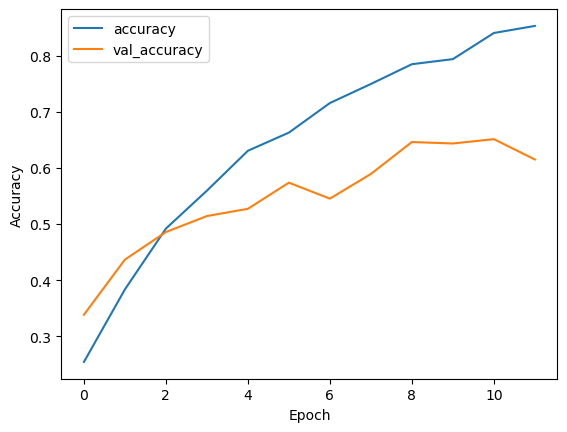

              precision    recall  f1-score   support

           0       0.18      0.09      0.12      1191
           1       0.07      0.10      0.08       431
           2       0.08      0.09      0.08       479
           3       0.14      0.09      0.11       690
           4       0.04      0.03      0.04       379
           5       0.07      0.09      0.08       413
           6       0.08      0.14      0.11       462
           7       0.11      0.14      0.12       679
           8       0.08      0.08      0.08       517
           9       0.14      0.15      0.15       808

    accuracy                           0.10      6049
   macro avg       0.10      0.10      0.10      6049
weighted avg       0.11      0.10      0.10      6049



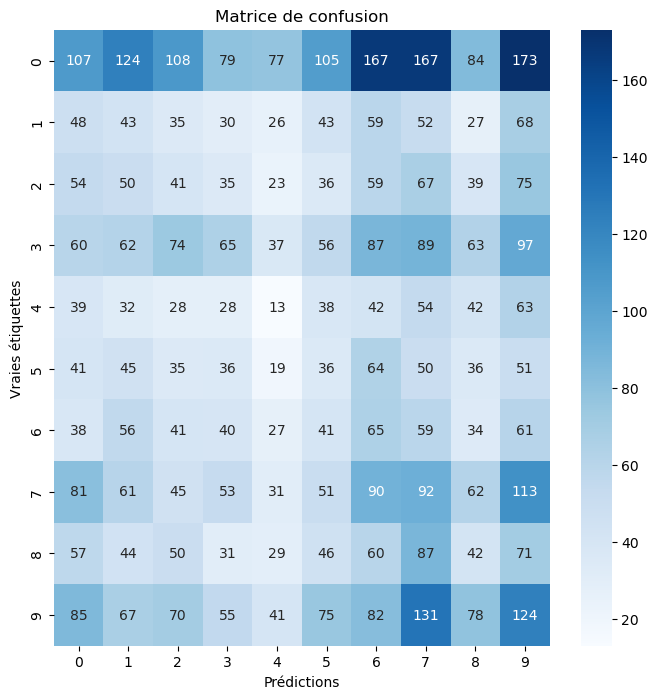

In [36]:
if generator_choice == 'keras':
  test_loss, test_accuracy = model.evaluate(test_generator)
  y_pred = model.predict(test_generator)

  id_classes = {
    "Agaricales":0,
    "Agaricus":1,
    "Amanita":2,
    "Cortinarius":3,
    "Entoloma":4,
    "Inocybe":5,
    "Mycena":6,
    "Polyporales":7,
    "Psathyrella":8,
    "Russula":9}

  y_true = test_data['label'].replace(id_classes)

else:
  test_loss, test_accuracy = model.evaluate(ds_test)
  y_pred = model.predict(ds_test)
  y_true = ds_test



y_pred_classes = np.argmax(y_pred, axis=1)
print("Test accuracy:", test_accuracy)

# Courbe d'évolution accuracy et val_accuracy lors de l'entrainement
import matplotlib.pyplot as plt
plt.plot(history['accuracy'], label='accuracy')
plt.plot(history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
#plt.ylim([0,1])
plt.legend()
plt.show()



# Rapport de classification
from sklearn.metrics import classification_report
report = classification_report(y_true, y_pred_classes)
print(report)


# Matrice de confusion
import seaborn as sns
from sklearn.metrics import confusion_matrix

confusion_mtx = confusion_matrix(y_test, y_pred_classes)
# Créer une figure pour afficher la matrice de confusion
plt.figure(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Prédictions')
plt.ylabel('Vraies étiquettes')
plt.title('Matrice de confusion')
plt.show()

# Predictions

## Image aléatoire du jeu de données

In [ ]:
(en construction)

## Image Web

In [ ]:
import requests
import cv2

url = 'https://www.hautesavoiephotos.com/champis/russula-aurea.jpg'

response = requests.get(url)
if response.status_code == 200:
    image_data = response.content
    img_web = cv2.imdecode(np.frombuffer(image_data, np.uint8), cv2.IMREAD_COLOR)
    img_web = cv2.cvtColor(img_web, cv2.COLOR_BGR2RGB)

    w = image.img_to_array(img_web)
    w = np.expand_dims(w, axis=0)
    w = preprocess_input(w)
    
    print("Image chargée sous la variable 'w'")

else:
    print(f"La requête a échoué avec le code d'état {response.status_code}")

In [ ]:
# Faites une prédiction avec le modèle sur l'image web chargée
predictions_web = model.predict(w)
index_classe_web = np.argmax(predictions_web)
nom_classe_predite = nom_classes[index_classe_web]

# Obtenir la classe réelle par rapport au chemin de l'image
plt.figure(figsize=(4, 4))
plt.imshow(img_web)
plt.title(f'Classe prédite : {nom_classe_predite}')
plt.axis('off')
plt.show()

1/1 [==============================] - 2s 2s/step
